# Bitcoin Marketplace Rating Predictions

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import itertools

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve


import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
plt.style.use('ggplot')

import sys
sys.path.insert(0, '../src')
import helpers as h
import visualizations as v
import time

#### Import Model Features

In [2]:
df_historical = pd.read_csv('../data/historical_features.csv')

# Create Subset of High Value Rating Transactions
mask = df_historical[(df_historical['num_neg_received']==0) & 
                        (df_historical['num_pos_received']>=3)]

# Create Subset of High Value Rating Transactions with fraud but suspicious removed
# df_mask = df_historical[(df_historical['num_neg_received']==0) & 
#                         (df_historical['num_pos_received']>=3) & 
#                         ((df_historical['rating']>0) | (df_historical['rating']==-10))]

df_historical.drop(['color', 'penwidth'], inplace=True, axis=1)
df_historical = df_historical[df_historical.index.isin(mask.index)]

df_velocity = pd.read_csv('../data/velocity_features.csv')
df_velocity.drop(['color', 'penwidth'], inplace=True, axis=1)
df_velocity = df_velocity[df_velocity.index.isin(mask.index)]

df_graph = pd.read_csv('../data/graph_features.csv')
df_graph.drop(['color', 'penwidth'], inplace=True, axis=1)
df_graph = df_graph[df_graph.index.isin(mask.index)]

# Merge All Three Feature Categories
merge_cols = ['ratee','rater','date','rating']
dfs = [df_historical, df_velocity, df_graph]
df_all = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), dfs)

# Combos of Feature Categories
dfs = [df_historical, df_velocity]
df_hv = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), dfs)

dfs = [df_historical, df_graph]
df_hg = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), dfs)

dfs = [df_velocity, df_graph]
df_gv = reduce(lambda left,right: pd.merge(left,right,on=merge_cols), dfs)

### Fit and Predict Feature Categories

In [3]:
def predict_on_features(df):
    X = df.copy()
    y = np.where(X['rating']<0, 1, 0) # set class as all negative ratings
    X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        stratify=y, shuffle=True,
                                                        random_state=123)
    model = RandomForestClassifier(n_jobs=-1, random_state=123)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = precision_recall_curve(y_test, proba)
    fpr, tpr, threshold = roc_curve(y_test, proba)
    accuracy = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    thresh = 0.2
    cnf_matrix = confusion_matrix(y_test, proba>=thresh)
    
    return pred, proba, precision, recall, thresholds, f1, cnf_matrix, fpr, tpr, accuracy, model 

In [4]:
h_pred, h_proba, h_precision, h_recall, h_thresholds, h_f1, h_cm, h_fpr, h_tpr, h_accuracy, h_model = predict_on_features(df_historical)
v_pred, v_proba, v_precision, v_recall, v_thresholds, v_f1, v_cm, v_fpr, v_tpr, v_accuracy, v_model = predict_on_features(df_velocity)
g_pred, g_proba, g_precision, g_recall, g_thresholds, g_f1, g_cm, g_fpr, g_tpr, g_accuracy, g_model = predict_on_features(df_graph)
a_pred, a_proba, a_precision, a_recall, a_thresholds, a_f1, a_cm, a_fpr, a_tpr, a_accuracy, a_model = predict_on_features(df_all)
hv_pred, hv_proba, hv_precision, hv_recall, hv_thresholds, hv_f1, hv_cm, hv_fpr, hv_tpr, hv_accuracy, hv_model = predict_on_features(df_hv)

In [5]:
# model = RandomForestClassifier(bootstrap = True,
#                                max_depth = 15,
#                                max_features = 4,
#                                min_samples_leaf = 3,
#                                min_samples_split = 7,
#                                n_estimators = 1000,
#                                n_jobs=-1,
#                                random_state=123)

#### ROC AUC Plot

In [6]:
def roc_curve(ax):
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(g_fpr, g_tpr, 'r', label = f'g_AUC = {auc(g_fpr, g_tpr):.2f}')
    ax.plot(v_fpr, v_tpr, 'g', label = f'v_AUC = {auc(v_fpr, v_tpr):.2f}')
    ax.plot(h_fpr, h_tpr, 'c', label = f'h_AUC = {auc(h_fpr, h_tpr):.2f}')
    ax.plot(hv_fpr, hv_tpr, 'b--', label = f'hv_AUC = {auc(hv_fpr, hv_tpr):.2f}')
    ax.plot(a_fpr, a_tpr, 'b', label = f'hvg_AUC = {auc(a_fpr, a_tpr):.2f}')
    ax.legend(loc = 'lower right')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

#### Precision Recall Curve

In [7]:
def pr_curve(ax):
    ax.set_title("Precision Recall Curve")
    ax.plot(g_recall, g_precision, alpha=0.8, c='r', label=f"Graph Features Rating (f1 score = {g_f1:.2f})")
    ax.plot(v_recall, v_precision, alpha=0.8, c='g', label=f"Velocity Features (f1 score = {v_f1:.2f})")
    ax.plot(h_recall, h_precision, alpha=0.8, c='c', label=f"Historical Features Model (f1 score = {h_f1:.2f})")
    ax.plot(hv_recall, hv_precision, alpha=0.8, c='b', linestyle='--', label=f"Hist & Vel Features (f1 score = {hv_f1:.2f})")
    ax.plot(a_recall, a_precision, alpha=0.8, c='b', label=f"All Features (f1 score = {a_f1:.2f})")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="upper right", frameon=False)

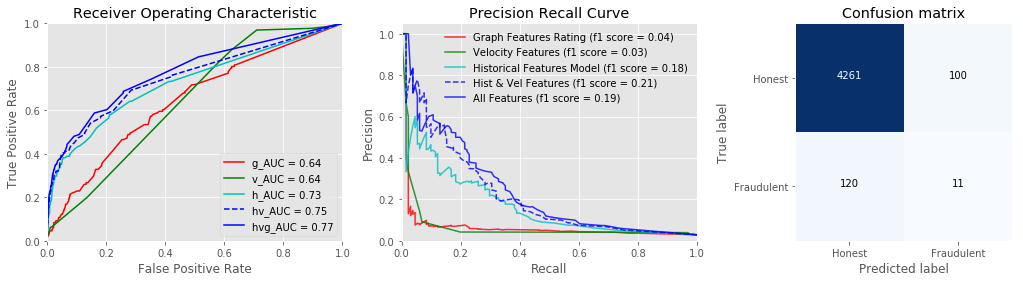

In [8]:
fig, axs = plt.subplots(1,3,figsize=(18,4))
roc_curve(axs[0])
pr_curve(axs[1])
v.plot_confusion_matrix(axs[2], g_cm, 
                      classes=['Honest','Fraudulent'], 
                      normalize=False,
                      title='Confusion matrix')
plt.show()

### Feature Importance

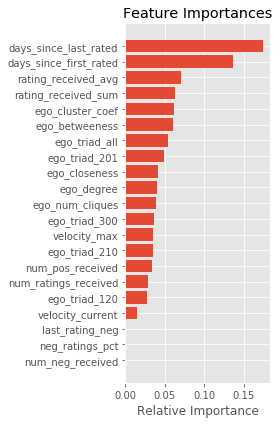

In [9]:
X = df_all.copy()
X = X.drop(['rater', 'ratee', 'rating', 'date'], axis=1)
features=X.columns
importances = a_model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(4,6))
ax.set_title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()

### Collusion Example

In [10]:
# Predict on Example 
x_pred = features_df[(features_df['ratee']==4986)].copy()
model = RandomForestClassifier(n_jobs=-1,
                               random_state=123)
model.fit(X_train, y_train)
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features

NameError: name 'features_df' is not defined

In [ ]:
# Predict on Example (with no features)
model_ng = RandomForestClassifier(n_jobs=-1,
                                  random_state=123)
model_ng.fit(X_train, y_train)
x = features_df_ng[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date', 'class'], axis=1, inplace=True)

In [ ]:
x_pred = features_df_ng[(features_df_ng['ratee']==4986)].copy()

x = x_pred.drop(['rater', 'ratee', 'rating','date'], axis=1)
y = x.pop('class')

# run model without graph features
pred_no_features = model_ng.predict_proba(x)[:,1]
x_pred = x_pred[['ratee','date','rating']]
x_pred['prediction_without_features'] = pred_no_features

In [ ]:
# rerun model with graph features
x = features_df[(features_df['ratee']==4986)].copy()
x.drop(['rater', 'ratee', 'rating','date'], axis=1, inplace=True)
y = x.pop('class')

pred_with_features = model.predict_proba(x)[:,1]
x_pred['prediction_with_features'] = pred_with_features
x_pred